# Chapter 5 NLP

In [2]:
%matplotlib inline

In [38]:
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import scattertext

import tensorflow as tf

from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import SimpleRNN, GRU, LSTM
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

from spacy.en import English

sns.set()

In [2]:
# import codecs
# import os
# import collections
# from six.moves import cPickle
# import numpy as np


# class TextLoader():
#     def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
#         self.data_dir = data_dir
#         self.batch_size = batch_size
#         self.seq_length = seq_length
#         self.encoding = encoding

#         input_file = os.path.join(data_dir, "input.txt")
#         vocab_file = os.path.join(data_dir, "vocab.pkl")
#         tensor_file = os.path.join(data_dir, "data.npy")

#         if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
#             print("reading text file")
#             self.preprocess(input_file, vocab_file, tensor_file)
#         else:
#             print("loading preprocessed files")
#             self.load_preprocessed(vocab_file, tensor_file)
#         self.create_batches()
#         self.reset_batch_pointer()

#     def preprocess(self, input_file, vocab_file, tensor_file):
#         with codecs.open(input_file, "r", encoding=self.encoding) as f:
#             data = f.read()
#         counter = collections.Counter(data)
#         count_pairs = sorted(counter.items(), key=lambda x: -x[1])
#         self.chars, _ = zip(*count_pairs)
#         self.vocab_size = len(self.chars)
#         self.vocab = dict(zip(self.chars, range(len(self.chars))))
#         with open(vocab_file, 'wb') as f:
#             cPickle.dump(self.chars, f)
#         self.tensor = np.array(list(map(self.vocab.get, data)))
#         np.save(tensor_file, self.tensor)

#     def load_preprocessed(self, vocab_file, tensor_file):
#         with open(vocab_file, 'rb') as f:
#             self.chars = cPickle.load(f)
#         self.vocab_size = len(self.chars)
#         self.vocab = dict(zip(self.chars, range(len(self.chars))))
#         self.tensor = np.load(tensor_file)
#         self.num_batches = int(self.tensor.size / (self.batch_size *
#                                                    self.seq_length))

#     def create_batches(self):
#         self.num_batches = int(self.tensor.size / (self.batch_size *
#                                                    self.seq_length))

#         # When the data (tensor) is too small,
#         # let's give them a better error message
#         if self.num_batches == 0:
#             assert False, "Not enough data. Make seq_length and batch_size small."

#         self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
#         xdata = self.tensor
#         ydata = np.copy(self.tensor)
#         ydata[:-1] = xdata[1:]
#         ydata[-1] = xdata[0]
#         self.x_batches = np.split(xdata.reshape(self.batch_size, -1),
#                                   self.num_batches, 1)
#         self.y_batches = np.split(ydata.reshape(self.batch_size, -1),
#                                   self.num_batches, 1)

#     def next_batch(self):
#         x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
#         self.pointer += 1
#         return x, y

#     def reset_batch_pointer(self):
#         self.pointer = 0

# data_dir = 'text'
# batch_size = 50
# seq_length = 50

# data_loader = TextLoader(data_dir, batch_size, seq_length)
# q = data_loader.next_batch()

# top_words = 5000
# max_words = 500

# (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)
# X = numpy.concatenate((X_train, X_test), axis=0)
# y = numpy.concatenate((y_train, y_test), axis=0)

# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# model = Sequential()
# model.add(Embedding(top_words, 32, input_length=max_words))
# model.add(Flatten())
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

# # create the model
# model = Sequential()
# model.add(Embedding(top_words, 32, input_length=max_words))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# embed_dim = 128
# lstm_out = 196

# model = Sequential()
# model.add(Embedding(top_words, embed_dim, input_length = max_words, dropout=0.2))
# model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

### Basics

In [5]:
corpus = [
    "movie was awesome, a must see",
    "wasn't overly impressed with the movie",
    'the movie was not good at all, it was a waste of time',
]

In [8]:
vocab = {
    token
    for sentence in corpus
    for token in sentence.split()
}
token_to_index = dict(zip(vocab, range(len(vocab))))
token_to_index

{'a': 5,
 'all,': 16,
 'at': 2,
 'awesome,': 10,
 'good': 12,
 'impressed': 13,
 'it': 17,
 'movie': 3,
 'must': 0,
 'not': 15,
 'of': 14,
 'overly': 7,
 'see': 4,
 'the': 6,
 'time': 1,
 'was': 9,
 "wasn't": 8,
 'waste': 18,
 'with': 11}

In [9]:
[
    [token_to_index[token] for token in sentence.split()]
    for sentence in corpus
]

[[3, 9, 10, 5, 0, 4],
 [8, 7, 13, 11, 6, 3],
 [6, 3, 9, 15, 12, 2, 16, 17, 9, 5, 18, 14, 1]]

In [10]:
# BOW
pd.DataFrame([
    Counter(sentence.split())
    for sentence in corpus
]).fillna(0)

,a,"all,",at,"awesome,",good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn't,waste,with
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0


In [11]:
cv = CountVectorizer()
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [12]:
# binary, jusy saying
cv = CountVectorizer(binary=True)
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,0,1,0


In [13]:
# exact same tokenizer
cv = CountVectorizer(tokenizer=lambda sentence: sentence.split())
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,a,"all,",at,"awesome,",good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn't,waste,with
0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [14]:
cv = CountVectorizer(vocabulary={'awesome', 'good', 'waste'})
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,awesome,good,waste
0,1,0,0
1,0,0,0
2,0,1,1


In [15]:
cv = CountVectorizer(ngram_range=(1, 2), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,good waste,impressed,impressed movie,movie,movie awesome,movie good,overly,overly impressed,time,wasn,wasn overly,waste,waste time
0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0
2,0,1,1,0,0,1,0,1,0,0,1,0,0,1,1


In [16]:
class LemmaTokenizer(object):
    def __init__(self):
        # self.wnl = WordNetLemmatizer()
        # self.wnl = PorterStemmer()
        # self.wnl = LancasterStemmer()
        self.wnl = SnowballStemmer(language='english')
    def __call__(self, articles):
        # return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        return [self.wnl.stem(t) for t in word_tokenize(articles)]

In [17]:
WordNetLemmatizer().lemmatize("puppies")

'puppy'

In [18]:
nlp = English()

In [19]:
[w.lemma_ for w in nlp(corpus[0])]

['movie', 'be', 'awesome', ',', 'a', 'must', 'see']

In [20]:
def tokenizeText(sample):

    # get the tokens using spaCy
    parser = English()
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import string
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

cv = CountVectorizer(tokenizer=tokenizeText)
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,impressed,movie,overly,time,waste
0,1,0,0,1,0,0,0
1,0,0,1,1,1,0,0
2,0,1,0,1,0,1,1


#### n-grams

In [21]:
cv = CountVectorizer(ngram_range=(1, 2))
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,all,all it,at,at all,awesome,awesome must,good,good at,impressed,impressed with,...,was,was awesome,was not,was waste,wasn,wasn overly,waste,waste of,with,with the
0,0,0,0,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,1,1
2,1,1,1,1,0,0,1,1,0,0,...,2,0,1,1,0,0,1,1,0,0


In [22]:
cv = CountVectorizer(ngram_range=(1, 12))
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,all,all it,all it was,all it was waste,all it was waste of,all it was waste of time,at,at all,at all it,at all it was,...,wasn overly impressed,wasn overly impressed with,wasn overly impressed with the,wasn overly impressed with the movie,waste,waste of,waste of time,with,with the,with the movie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,0


In [23]:
cv = CountVectorizer(ngram_range=(1, 2), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,good waste,impressed,impressed movie,movie,movie awesome,movie good,overly,overly impressed,time,wasn,wasn overly,waste,waste time
0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0
2,0,1,1,0,0,1,0,1,0,0,1,0,0,1,1


In [24]:
cv = CountVectorizer(ngram_range=(1, 12), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,good waste,good waste time,impressed,impressed movie,movie,movie awesome,movie good,movie good waste,...,overly,overly impressed,overly impressed movie,time,wasn,wasn overly,wasn overly impressed,wasn overly impressed movie,waste,waste time
0,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,0,0,0,...,1,1,1,0,1,1,1,1,0,0
2,0,1,1,1,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,1


### tfidf

In [25]:
corpus[1]

"wasn't overly impressed with the movie"

In [26]:
a.todense()[1, :].sum()

10

In [27]:
tfidf = CountVectorizer()
a = tfidf.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=tfidf.get_feature_names())

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [28]:
tfidf = TfidfVectorizer()
a = tfidf.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=tfidf.get_feature_names())

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0.000000,0.000000,0.504611,0.000000,0.000000,0.000000,0.298032,0.504611,0.000000,0.000000,0.000000,0.504611,0.000000,0.000000,0.383770,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.450504,0.000000,0.266075,0.000000,0.000000,0.000000,0.450504,0.000000,0.342620,0.000000,0.000000,0.450504,0.000000,0.450504
2,0.298264,0.298264,0.000000,0.298264,0.000000,0.298264,0.176160,0.000000,0.298264,0.298264,0.000000,0.000000,0.226837,0.298264,0.453675,0.000000,0.298264,0.000000


### Inverse Document Frequency (IDF)

In [29]:
def idf(n_samples, df):
    return np.log((n_samples + 1) / (df + 1)) + 1

In [32]:
idf(3, 1)

1.6931471805599454

In [33]:
idf(3, 2)

1.2876820724517808

In [34]:
idf(3, 3)

1.0

In [35]:
# l2 normalization
a = np.array([idf(3, 1), idf(3, 3), idf(3, 1), idf(3, 2), idf(3, 1), idf(3, 1)])
a / np.linalg.norm(a) 

array([0.45050407, 0.26607496, 0.45050407, 0.34261996, 0.45050407,
       0.45050407])

In [36]:
idf(10, 1)

2.7047480922384253

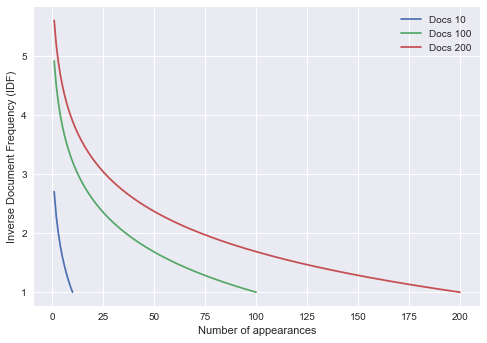

In [39]:
for docs in [10, 100, 200]:
    docs_range = range(1, docs + 1)
    plt.plot(docs_range, [idf(docs, d) for d in docs_range], label='Docs {}'.format(docs))
    
plt.xlabel('Number of appearances')
plt.ylabel('Inverse Document Frequency (IDF)')
plt.legend();

### Logistic Regression

In [40]:
x = tfidf.transform(corpus).toarray()
y = [1, 0, 0]

In [41]:
lr = LogisticRegression()
lr.fit(x, y)
lr.predict(x)

array([1, 0, 0])

In [42]:
lr.coef_[0].shape

(18,)

In [43]:
len(lr.coef_[0])

18

In [44]:
def plot_lr_coefficients(tfidf):
    a = tfidf.fit_transform(corpus)
    x = tfidf.transform(corpus).toarray()
    lr = LogisticRegression()
    lr.fit(x, y)
    df = pd.DataFrame({'Token': tfidf.get_feature_names(), 'Coefficient': lr.coef_[0]})
    df['Positive'] = df.Coefficient > 0
    colors = df.Positive.map({True: 'b', False: 'r'})
    df.set_index('Token').plot(kind='barh', color=[colors], legend=False, figsize=(8, 6))
    plt.xlabel('Coefficient')

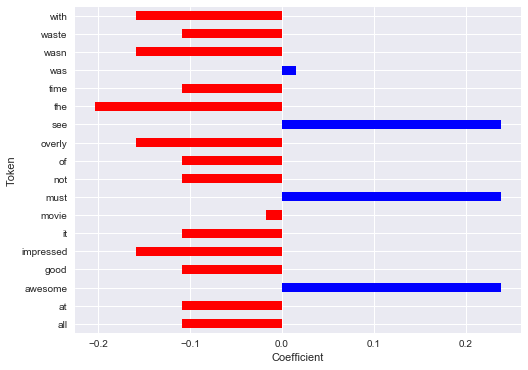

In [45]:
plot_lr_coefficients(TfidfVectorizer())

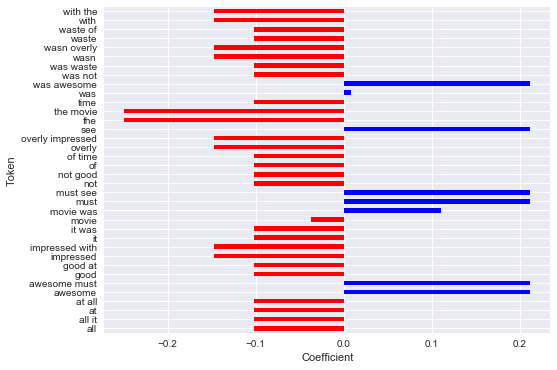

In [46]:
plot_lr_coefficients(CountVectorizer(ngram_range=(1, 2)))

### IMDB review sentiment data

In [442]:
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xzf aclImdb_v1.tar.gz
# !rm aclImdb_v1.tar.gz

--2018-05-15 18:45:20--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu... 171.64.68.10
Connecting to ai.stanford.edu|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.5MB/s    in 5.3s    

2018-05-15 18:45:26 (15.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [47]:
def get_reviews(data_partition, class_label):
    path = 'aclImdb/{}/{}/*.txt'.format(data_partition, class_label)
    return [
        open(f).read()
        for f in glob.glob(path)
    ]

In [48]:
def get_dataset(data_partition):
    pos = get_reviews(data_partition, 'pos')
    neg = get_reviews(data_partition, 'neg')
    print('Found {} positive and {} negative examples'.format(len(pos), len(neg)))
    data = pos + neg
    labels = [1 for _ in range(len(pos))] + [-1 for _ in range(len(neg))]
    return data, labels

In [49]:
%%time
data_train, y_train = get_dataset('train')
data_test, y_test = get_dataset('test')

Found 12500 positive and 12500 negative examples
Found 12500 positive and 12500 negative examples
CPU times: user 3.59 s, sys: 4.89 s, total: 8.47 s
Wall time: 15.9 s


In [50]:
len(data_train)

25000

In [51]:
len(data_test)

25000

In [52]:
data_train[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [53]:
data_train[12500]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [54]:
%%time
vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_df=3/4, min_df=2)
x_train = vec.fit_transform(data_train)

CPU times: user 5 s, sys: 161 ms, total: 5.16 s
Wall time: 5.18 s


In [55]:
len(vec.vocabulary_)

44490

In [56]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
%%time
x_test = vec.transform(data_test)

CPU times: user 5.21 s, sys: 150 ms, total: 5.36 s
Wall time: 5.42 s


In [58]:
cross_val_score(LogisticRegression(), x_train, y_train, cv=5)

array([0.864 , 0.847 , 0.8512, 0.8504, 0.8638])

In [59]:
def traditional_ml(vec_class, model_object, stop_words, ngram_range, max_df, min_df, cv):
    vec = vec_class(stop_words=stop_words,
                    ngram_range=ngram_range,
                    max_df=max_df, min_df=min_df)
    x_train = vec.fit_transform(data_train)
    print('Vocabulary size: {}'.format(len(vec.vocabulary_)))
    x_test = vec.transform(data_test)
    scores = cross_val_score(model_object, x_train, y_train, cv=cv)
    scores_mean = scores.mean()
    scores_std = scores.std()
    print('Cross-validation scores mean: {:.2f}%, std: {:.2f}%'.format(scores_mean * 100,
                                                                       scores_std * 100))

In [60]:
%%time
traditional_ml(TfidfVectorizer, LogisticRegression(), 'english', (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44490
Cross-validation scores mean: 85.53%, std: 0.72%
CPU times: user 12.4 s, sys: 407 ms, total: 12.8 s
Wall time: 12.9 s


In [61]:
%%time
traditional_ml(CountVectorizer, LogisticRegression(), 'english', (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44490
Cross-validation scores mean: 82.97%, std: 1.15%
CPU times: user 20.3 s, sys: 338 ms, total: 20.7 s
Wall time: 20.7 s


In [62]:
%%time
traditional_ml(TfidfVectorizer, LogisticRegression(), None, (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44789
Cross-validation scores mean: 86.27%, std: 0.56%
CPU times: user 14.2 s, sys: 409 ms, total: 14.6 s
Wall time: 14.6 s


In [63]:
%%time
traditional_ml(CountVectorizer, LogisticRegression(), None, (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44789
Cross-validation scores mean: 83.88%, std: 1.19%
CPU times: user 32.7 s, sys: 569 ms, total: 33.2 s
Wall time: 33.5 s


In [64]:
%%time
traditional_ml(TfidfVectorizer, RandomForestClassifier(), None, (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44789
Cross-validation scores mean: 74.56%, std: 0.68%
CPU times: user 38.1 s, sys: 654 ms, total: 38.7 s
Wall time: 38.9 s


### Deep learning

#### MLP

In [66]:
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               11389696  
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0      

In [16]:
history = model.fit(x_train.toarray(), to_categorical(y_train),
          epochs=5, batch_size=128,
          validation_split=1/3);

Train on 16666 samples, validate on 8334 samples
Epoch 1/5
16666/16666 [==============================] - 41s - loss: 0.0511 - acc: 0.9970 - val_loss: 6.3021e-05 - val_acc: 1.0000
Epoch 2/5
16666/16666 [==============================] - 41s - loss: 6.3025e-05 - acc: 1.0000 - val_loss: 3.3068e-05 - val_acc: 1.0000
Epoch 3/5
16666/16666 [==============================] - 36s - loss: 3.3027e-05 - acc: 1.0000 - val_loss: 1.9238e-05 - val_acc: 1.0000
Epoch 4/5
16666/16666 [==============================] - 36s - loss: 1.7615e-05 - acc: 1.0000 - val_loss: 1.2502e-05 - val_acc: 1.0000
Epoch 5/5
16666/16666 [==============================] - 41s - loss: 1.1388e-05 - acc: 1.0000 - val_loss: 8.6410e-06 - val_acc: 1.0000


In [110]:
# model.evaluate(x_test.toarray(), to_categorical(y_test))

In [25]:
model.get_weights()[0].shape

(44490, 256)

In [31]:
vec.get_feature_names().index('awesome')

2981

In [33]:
vec.get_feature_names().index('terrible')

39522

In [ ]:
model.get_weights()[0]

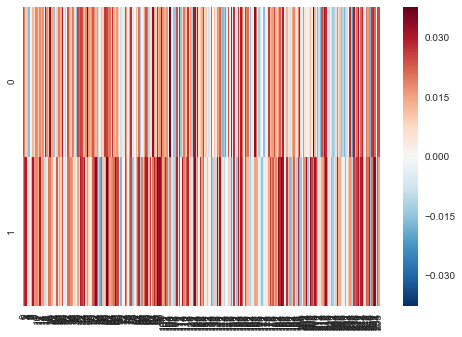

In [41]:
sns.heatmap(model.get_weights()[0][[2981, 39522]]) 

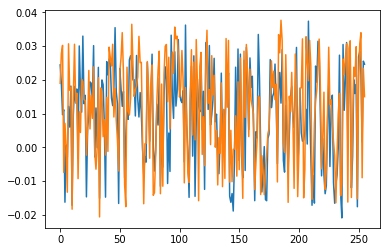

In [37]:
pd.Series(model.get_weights()[0][2981]).plot()
pd.Series(model.get_weights()[0][39522]).plot()

In [44]:
y_train[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [70]:
labels = ['Positive' if y == 1 else 'Negative' for y in y_train]
scattertext_df = pd.DataFrame({'text': data_train, 'label': labels})
corpus = scattertext.CorpusFromPandas(scattertext_df,
                                      category_col='label', text_col='text',
                                      nlp=scattertext.whitespace_nlp_with_sentences).build()

In [71]:
type(corpus)

scattertext.Corpus.Corpus

In [72]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['doesn', 'didn', 'isn', 've', 'wasn', 'film', 'don', 'plot', 'acting', 'scenes']


In [73]:
html = scattertext.produce_scattertext_explorer(corpus,
                                                category='Positive',
                                                category_name='Positive',
                                                not_category_name='Negative',
                                                width_in_pixels=1000
                                               )
open("imdb-vis.html", 'wb').write(html.encode('utf-8'))

41148975

In [74]:
term_freq_df = corpus.get_term_freq_df()
tf = term_freq_df.copy()

In [75]:
tf = tf[(tf['Positive freq'] > 0) & (tf['Negative freq'] > 0)]
tf['ratio'] = tf['Positive freq'] / tf['Negative freq']
tf.sort_values(by='ratio', ascending=True)

,Negative freq,Positive freq,ratio
term,,,
boll,141,1,0.007092
worst films,103,1,0.009709
uwe,99,1,0.010101
uwe boll,85,1,0.011765
just bad,81,1,0.012346
this crap,144,2,0.013889
avoid at,62,1,0.016129
thunderbirds,61,1,0.016393
beowulf,60,1,0.016667


In [12]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
    
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=128, verbose=1)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = cross_val_score(model, x_train.toarray(), to_categorical(y_train), cv=3)

Epoch 1/5
16666/16666 [==============================] - 38s - loss: 0.0477 - acc: 0.9986    
Epoch 2/5
16666/16666 [==============================] - 31s - loss: 5.8580e-05 - acc: 1.0000    
Epoch 3/5
16666/16666 [==============================] - 30s - loss: 3.1107e-05 - acc: 1.0000    
Epoch 4/5
16666/16666 [==============================] - 29s - loss: 1.9155e-05 - acc: 1.0000    
Epoch 5/5
16667/16667 [==============================] - 39s - loss: 0.0508 - acc: 0.9986    
Epoch 2/5
16667/16667 [==============================] - 31s - loss: 5.5399e-05 - acc: 1.0000    
Epoch 3/5
16667/16667 [==============================] - 31s - loss: 3.0268e-05 - acc: 1.0000    
Epoch 4/5
16667/16667 [==============================] - 32s - loss: 1.7954e-05 - acc: 1.0000    
Epoch 5/5
16667/16667 [==============================] - 39s - loss: 0.0574 - acc: 0.9951    
Epoch 2/5
16667/16667 [==============================] - 30s - loss: 6.8239e-05 - acc: 1.0000    
Epoch 3/5
16667/16667 [=========

In [13]:
results

array([1., 1., 1.])

### embeddings

#### learned

In [79]:
def create_model():
    model = Sequential()
    model.add(Embedding(x_train.shape[1], 300))
    # model.add(Flatten())
    # model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2))
    model.add(Activation('softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=128, verbose=1)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = cross_val_score(model, x_train.toarray(), to_categorical(y_train), cv=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         13347000  
_________________________________________________________________
dense_18 (Dense)             (None, None, 250)         75250     
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 250)         0         
_________________________________________________________________
dense_19 (Dense)             (None, None, 128)         32128     
_________________________________________________________________
activation_18 (Activation)   (None, None, 128)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
dense_20 (Dense)             (None, None, 2)           258       
__________

ValueError: Error when checking model target: expected activation_19 to have 3 dimensions, but got array with shape (16666, 2)

#### pre-trained

### Sequence

### sequences

In [249]:
from keras.preprocessing.text import Tokenizer, one_hot, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

In [248]:
text_to_word_sequence(corpus[0])

['movie', 'was', 'awesome', 'a', 'must', 'see']

In [250]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [252]:
tokenizer.document_count

3

In [253]:
tokenizer.word_index

{'a': 3,
 'all': 5,
 'at': 10,
 'awesome': 11,
 'good': 7,
 'impressed': 9,
 'it': 13,
 'movie': 1,
 'must': 15,
 'not': 6,
 'of': 14,
 'overly': 18,
 'see': 12,
 'the': 4,
 'time': 19,
 'was': 2,
 "wasn't": 16,
 'waste': 8,
 'with': 17}

In [264]:
tokenizer.index_docs

{1: 3,
 2: 2,
 3: 2,
 4: 2,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1}

In [257]:
len(tokenizer.word_index)

19

In [254]:
tokenizer.texts_to_sequences(corpus)

[[1, 2, 11, 3, 15, 12],
 [16, 18, 9, 17, 4, 1],
 [4, 1, 2, 6, 7, 10, 5, 13, 2, 3, 8, 14, 19]]

In [261]:
sequences = tokenizer.texts_to_sequences(corpus)
data = pad_sequences(sequences, maxlen=10, padding='pre')
data

array([[ 0,  0,  0,  0,  1,  2, 11,  3, 15, 12],
       [ 0,  0,  0,  0, 16, 18,  9, 17,  4,  1],
       [ 6,  7, 10,  5, 13,  2,  3,  8, 14, 19]], dtype=int32)

In [267]:
index_to_word = dict((v,k) for k,v in tokenizer.word_index.items())

In [271]:
[
 [index_to_word.get(token, 'X') for token in sentence]
 for sentence in data
]

[['X', 'X', 'X', 'X', 'movie', 'was', 'awesome', 'a', 'must', 'see'],
 ['X', 'X', 'X', 'X', "wasn't", 'overly', 'impressed', 'with', 'the', 'movie'],
 ['not', 'good', 'at', 'all', 'it', 'was', 'a', 'waste', 'of', 'time']]

In [272]:
from keras.utils import to_categorical

In [275]:
to_categorical([0, 1, 1, 2, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [ ]:
tfidf = TfidfVectorizer()


### MLP

In [214]:
from keras.datasets import imdb

In [9]:
model = Sequential()
model.add(SimpleRNN(3, input_shape=(2, 1), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', )

### RNN

### LSTM

### Seq2Seq

### Sentiment Analysis

### Machine Translation

### Chatbots